In [1]:
from sqlalchemy import create_engine
import time
from datetime import timedelta, date, datetime
import numpy as np
import pandas as pd
import warnings
import pandas as pd
from fbprophet import Prophet
warnings.simplefilter('ignore')
from sklearn import metrics

In [2]:
from google.colab import files
import io
uploaded = files.upload()

Saving Global DataBase3.csv to Global DataBase3.csv


In [3]:
#read dataframe from DB
df=pd.read_csv(io.BytesIO(uploaded['Global DataBase3.csv']), index_col='datetime', parse_dates=True, dayfirst=True)

df = df.sort_index()

#Handeling global outliers
GlobalOutliers =  []
for i in range(13):
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()
    
    
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']

df = df.dropna()

In [4]:
df = df.reset_index(level=0)
df = df[["Price - PT [€/MWh]", "datetime"]]
df.columns = ['y', 'ds']
df

,y,ds
0,58.82,2017-01-01 01:00:00
1,58.23,2017-01-01 02:00:00
2,51.95,2017-01-01 03:00:00
3,47.27,2017-01-01 04:00:00
4,46.90,2017-01-01 05:00:00
...,...,...
45594,277.80,2022-03-15 19:00:00
45595,297.01,2022-03-15 20:00:00
45596,311.71,2022-03-15 21:00:00
45597,304.19,2022-03-15 22:00:00


In [5]:
# split into train and test sets
size = int(len(df) * 0.8)
train, test = df[0:size], df[size:len(df)]

m = Prophet(interval_width=0.95)
start_time = time.time()
model = m.fit(train)
exec_time = time.time()-start_time

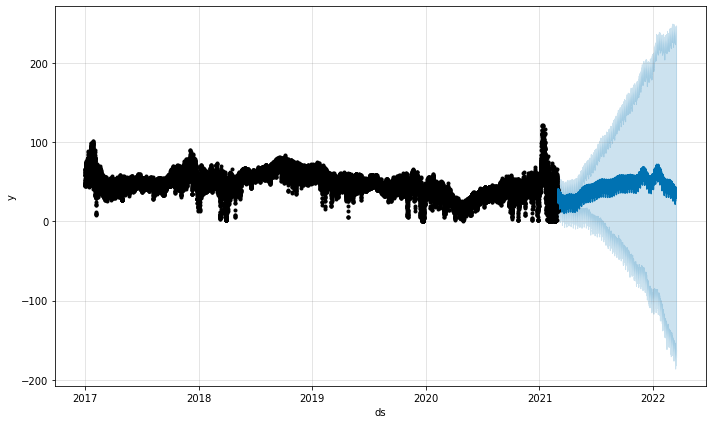

In [6]:
forecast = m.predict(test)
plot1 = m.plot(forecast)

In [7]:
inv_y = test['y']
inv_yhat = forecast['yhat']

#Calculate MAE, MSE, RMSE, CV
MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
MSE=metrics.mean_squared_error(inv_y, inv_yhat)
CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
R2= metrics.r2_score(inv_y, inv_yhat)

print('Mean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)  
print('Root Mean Squared Error:', np.sqrt(MSE))
print('Coefficient of Variance:',CV)
print('R2:', R2)
print('Execution Time:', '%.5f' %  exec_time)

Mean Absolute Error: 102.40563409075398
Mean Squared Error: 16468.268078569847
Root Mean Squared Error: 128.3287500078211
Coefficient of Variance: 88.58964469880942
R2: -1.2931785419396595
Execution Time: 116.36675
